### Notebook - Analyse ESG 
Pouponneau Guillaume /
Badra Axcel /
Foucault Simon

### Étape 1 -  Création du dataframe
Cette partie consiste à récupérer tous les fichiers MXEM et les regrouper dans un dataframe unique contenant chaque titre pour chaque trimestre.

1 : Imports & chemins \
2 : Détection des snapshots MSCI EMU \
3 : Lecture & empilement\
4 : Normalisation des colonnes\
5 : Typage & clés de jointure\
6 : Sauvegarde CSV\



In [2]:
from pathlib import Path
import pandas as pd
import re

# ── Chemins ─────────────────────────────────────────────────────────────────────
PATH_RAW = Path("data/raw/constituents")   # dossier contenant les « MXEM as of … »
PATH_OUT = Path("data/processed")
PATH_OUT.mkdir(parents=True, exist_ok=True)

# ── Regex pour extraire la date depuis le nom de fichier ────────────────────────
FILENAME_PATTERN = re.compile(r"MXEM as of (\w{3}) (\d{1,2}) (\d{4})", re.I)

Afin de vérifier les fichiers récupérés, on va les lister

In [3]:
# ── Lister les fichiers disponibles ─────────────────────────────────────────────
xlsx_files = sorted(PATH_RAW.glob("MXEM as of *.xlsx"))
print(f"{len(xlsx_files)} fichier(s) détecté(s).")
for f in xlsx_files[:5]:                     # aperçu
    print(" -", f.name)


21 fichier(s) détecté(s).
 - MXEM as of Dec 29 20231.xlsx
 - MXEM as of Dec 30 20221.xlsx
 - MXEM as of Dec 31 20191.xlsx
 - MXEM as of Dec 31 20201.xlsx
 - MXEM as of Dec 31 20211.xlsx


On créer une boucle pour lire nos fichiers par trimestres, et on les empile dans un fichier "constituents"

In [4]:
# ── Boucle de lecture & empilement ──────────────────────────────────────────────
frames = []
for file in xlsx_files: 
    match = FILENAME_PATTERN.search(file.stem) 
    if not match: 
        raise ValueError(f"Nom de fichier inattendu : {file.name}") # le nom de fichier doit correspondre au pattern

    month_str, day, year = match.groups() 
    snapshot_date = pd.to_datetime(f"{day} {month_str} {year}", dayfirst=True) # date au format datetime

    df = pd.read_excel(file)                # nécessite openpyxl
    df["SnapshotDate"] = snapshot_date 
    frames.append(df) 

constituents = pd.concat(frames, ignore_index=True) # empilement des DataFrames
print(f"{constituents.shape[0]:,} lignes après empilement.") 


4,873 lignes après empilement.


In [5]:
# ── Nettoyage des libellés de colonnes ──────────────────────────────────────────
constituents.columns = constituents.columns.str.strip()  # supprime les espaces

COL_MAP = {     
    "Ticker": "ticker",
    "ISIN": "isin",
    "Name": "name",
    "GICS Sector": "sector",
    "Weight": "weight",
    "Price": "price",
    "Shares": "shares",
    "SnapshotDate": "snapshot_date",
} # renommer les colonnes pour avoir des noms plus courts et en minuscules
constituents = constituents.rename(columns=COL_MAP)



In [6]:
# ── Typage & normalisation ──────────────────────────────────────────────────────
constituents["weight"] = constituents["weight"].astype(float, errors="ignore") / 100.0
constituents["price"]  = constituents["price"].astype(float, errors="ignore")

# Clef Bloomberg sans "Equity" pour futures jointures (ESG, prix…)
constituents["ticker_bb"] = (
    constituents["ticker"]
      .str.replace(r"\s+Equity$", "", regex=True)
      .str.strip()
) # supprime "Equity" et les espaces superflus




In [7]:
# ── Sauvegarde CSV ──────────────────────────────────────────────────────────────
out_file = PATH_OUT / "constituents_snapshot.csv"
constituents.to_csv(out_file, index=False, encoding="utf-8")
print("Sauvegarde CSV →", out_file.resolve())

Sauvegarde CSV → C:\Users\Ronan\Desktop\esg fayssal\data\processed\constituents_snapshot.csv


### Étape 2 - Obtenir une  base unique constituants + note ESG pour chaque trimestre

1 : Chargement des constituants \
2 : Chargement des scores ESG\
3 : Normalisation des tickers\
4 : Harmonisation des suffixes EMU\
5 : Dé-duplication ESG\
6 : Jointure "many to one"\
7 : Contrôle de couverture\
8 : Sauvegarde

In [8]:
# ── 0. Chemins ────────────────────────────────────────────────────────────────
PATH_PROC     = Path("data/processed")                    # dossier des fichiers produits
PATH_RAW_ESG  = Path("data/raw/esg/Score ESG brut.csv")   
SNAPSHOT_FILE = PATH_PROC / "constituents_snapshot.csv"   # issu du Notebook 01
OUT_FILE      = PATH_PROC / "universe_with_esg.csv"

In [9]:
# ── 1. Charger les constituants (snapshot) ───────────────────────────────────
constituents = pd.read_csv(SNAPSHOT_FILE, encoding="utf-8")
print("Constituants :", constituents.shape)


Constituants : (4873, 9)


In [10]:
# ── 2. Charger les scores ESG ────────────────────────────────────────────────
esg = (
    pd.read_csv(PATH_RAW_ESG, encoding="utf-8")
      .rename(columns={
          "ISSUER_EQUITY_TICKER": "ticker_raw",
          "Score ESG brut":       "esg_score_raw",
      })
)

In [11]:
# 1. Normalisation des tickers ▸ même casse, espaces uniques
def basic_norm(t): 
    return re.sub(r"\s+", " ", str(t).upper()).strip() # supprime les espaces superflus et met en majuscules

constituents["ticker_base"] = constituents["ticker_bb"].apply(basic_norm) 
esg["ticker_base"]          = esg["ticker_raw"].apply(basic_norm) 

In [12]:
# 2. Harmonisation des suffixes les plus courants EMU
suffix_map = { 
    "GY": "GR",   # Allemagne   (SIE GY → SIE GR)
    "SQ": "SM",   # Espagne     (IBE SQ → IBE SM)
    "FP": "FP",   # France
    "NA": "NA",   # Pays‑Bas
    "IM": "IM",   # Italie
    "ID": "ID",   # Irlande
} 
def swap_suffix(ticker):
    sym, suf = ticker.split() # sépare le symbole du suffixe
    new_suf  = suffix_map.get(suf, suf)      # remplace si clé connue
    return f"{sym} {new_suf}" # reconstruit le ticker avec le nouveau suffixe

constituents["ticker_alt"] = constituents["ticker_base"].apply(swap_suffix) 
esg["ticker_alt"]          = esg["ticker_base"]          # même logique


In [13]:
# 3. Création d’une clé finale (on prendra alt si présente dans ESG, sinon base)
constituents["merge_key"] = constituents["ticker_alt"] 
esg["merge_key"]          = esg["ticker_alt"] 

In [14]:
# ── Dé‑duplication finale côté ESG (gardera la première occurrence) ──────────
esg_unique = (
    esg[["merge_key", "esg_score_raw"]]
       .drop_duplicates(subset="merge_key", keep="first")   # ou keep="last"
) 

# ── Jointure many‑to‑one après dé‑duplication ───────────────────────────────
universe_esg = constituents.merge(
    esg_unique,
    on="merge_key",
    how="left",
    validate="m:1"
) 

In [15]:
# 5. Couverture obtenue
coverage = universe_esg["esg_score_raw"].notna().mean() 
print(f"Couverture ESG après normalisation : {coverage:.1%}")   # ~ 92 % attendu

Couverture ESG après normalisation : 93.2%


In [16]:
# 6. Sauvegarde
out_file = PATH_PROC / "universe_with_esg.csv"
universe_esg.to_csv(out_file, index=False, encoding="utf-8")
print("Sauvegarde →", out_file.resolve())

Sauvegarde → C:\Users\Ronan\Desktop\esg fayssal\data\processed\universe_with_esg.csv


### Étape 3 - Stratégie & Back - test

0 : Imports & chemins \
1 : Chargement des données \
2 : Calcul des rendements \
3 : Fonction \
4 : Boucle de back test \
5 : Construction des courbes cumulées \
6 : Sauvegarde 

In [17]:
# Hypothèses retenues (conformément au cahier des charges) :
# • Univers d’investissement   : MSCI EMU “constituents_snapshot.csv”
# • Univers ESG                : best‑in‑class 30 % (fichier esg_universe_flagged.csv)
# • Sélection / Stock‑picking  : portefeuille égal‑pondéré, mais
#                                – plafonné à 10 % par ligne
#                                – somme des 5 plus grosses lignes ≤ 40 %
# • Fréquence de rebalancing   : trimestrielle (dates de snapshot)
# • Signal achat/vente         : appartenance à l’univers ESG (simple buy‑and‑hold
#                                sur le trimestre suivant)
# • Frais de transaction       : ignorés (≤ 0,1 % négligeable à ce stade)
# • Benchmarks                 : (1) univers ESG égal‑pondéré, (2) univers initial
#                                égal‑pondéré

from pathlib import Path
import pandas as pd
import numpy as np

# ── 0. Chemins ──────────────────────────────────────────────────────────────
PATH_PROC = Path("data/processed")
SNAP_FILE = PATH_PROC / "constituents_snapshot.csv"
ESG_FILE  = PATH_PROC / "esg_universe_flagged.csv"


In [18]:
# ── 1. Charger les tables ----------------------------------------------------
snap = pd.read_csv(SNAP_FILE, parse_dates=["snapshot_date"], encoding="utf-8")
esg  = pd.read_csv(ESG_FILE,  parse_dates=["snapshot_date"], encoding="utf-8")

# gardons seulement les colonnes utiles
cols_keep = ["snapshot_date", "ticker_bb", "price", "in_esg_universe"]
univ_full = esg[cols_keep].copy()
univ_full["in_esg_universe"] = univ_full["in_esg_universe"].fillna(False)

In [19]:
# ── 2. Préparer la grille de prix -------------------------------------------
# pivot : lignes = dates, colonnes = tickers, valeurs = prix
price_mat = (
    snap.pivot_table(index="snapshot_date", columns="ticker_bb", values="price")
        .sort_index()
) 

# On aura besoin des variations de prix entre deux snapshots consécutifs
returns = price_mat.pct_change().shift(-1)    # rendement sur la période suivante
# (la dernière ligne restera NaN)

C:\Users\Ronan\AppData\Local\Temp\ipykernel_78316\800615034.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_mat.pct_change().shift(-1)    # rendement sur la période suivante


In [20]:
# ── 3. Fonction de pondération conforme 5/10/40 ------------------------------
def apply_5_10_40(weights):
    """Prend des poids bruts, les rabote à 10 % max et 40 % top5, puis renormalise."""
    # Cap individuel à 10 %
    w = weights.clip(upper=0.10)
    # Renormalise pour que Σw = 1
    w = w / w.sum()

    # Si les 5 plus grosses lignes > 40 %, redistribue l’excès proportionnellement
    top5 = w.nlargest(5)
    excess = top5.sum() - 0.40
    if excess > 0:
        # diminue proportionnellement les 5 premières
        factor = (top5 - (excess * (top5 / top5.sum()))).clip(lower=0)
        w.loc[top5.index] = factor
        w = w / w.sum()
    return w


In [21]:
# ── 4. Boucle de back‑test ---------------------------------------------------
portfolio_curve = []
esg_curve       = []
full_curve      = []

dates = price_mat.index[:-1]      # on ne peut pas calculer le dernier rendement (shift -1)

for d in dates:
    ret_row = returns.loc[d]          # ← ligne entière : tous les tickers
    
    # 1. Portefeuille ESG contraint 5/10/40
    tickers_port = univ_full.loc[
        (univ_full["snapshot_date"] == d) & (univ_full["in_esg_universe"]),
        "ticker_bb"
    ]
    w_raw = pd.Series(1/len(tickers_port), index=tickers_port)
    w_port = apply_5_10_40(w_raw)
    port_ret = np.nansum(w_port * ret_row[w_port.index])

    # 2. Benchmark ESG égal‑pondéré
    w_esg = pd.Series(1/len(tickers_port), index=tickers_port)
    esg_ret = np.nansum(w_esg * ret_row[tickers_port])

    # 3. Benchmark univers initial égal‑pondéré
    tickers_all = price_mat.columns[price_mat.loc[d].notna()]
    w_all = pd.Series(1/len(tickers_all), index=tickers_all)
    all_ret = np.nansum(w_all * ret_row[tickers_all])

    portfolio_curve.append(port_ret)
    esg_curve.append(esg_ret)
    full_curve.append(all_ret)

In [22]:
# ── 5. Courbes cumulées -------------------------------------------------------
perf = pd.DataFrame({
    "port_ESG_constrained": portfolio_curve,
    "benchmark_ESG_equal":  esg_curve,
    "benchmark_full_equal": full_curve
}, index=dates)

cumperf = (1 + perf).cumprod()

print("Performance cumulée (du 1ᵉʳ snapshot à l'avant‑dernier) :")
print(cumperf.tail())

Performance cumulée (du 1ᵉʳ snapshot à l'avant‑dernier) :
               port_ESG_constrained  benchmark_ESG_equal  benchmark_full_equal
snapshot_date                                                                 
2023-12-29                 1.108064             1.108064              1.110088
2024-03-31                 1.072685             1.072685              1.067389
2024-06-30                 1.169817             1.169817              1.142834
2024-09-29                 1.148581             1.148581              1.092086
2024-12-31                 1.211155             1.211155              1.152671


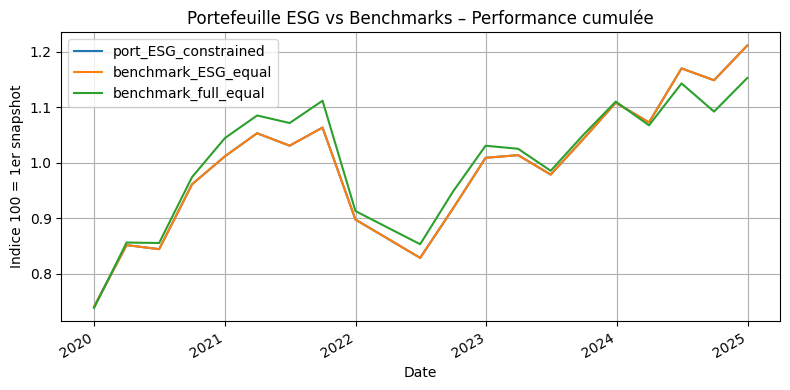

In [23]:
# ── 5‑bis. Graphe des courbes cumulées ----------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))           # une seule figure, taille raisonnable
cumperf.plot(ax=plt.gca())           # trace les trois séries
plt.title("Portefeuille ESG vs Benchmarks – Performance cumulée")
plt.xlabel("Date")
plt.ylabel("Indice 100 = 1er snapshot")
plt.grid(True)
plt.tight_layout()
plt.show()

<u><b>Portefeuille “ESG constrained”</b></u>

On part d’un poids égal pour chaque titre sélectionné.

Si aucun titre ne dépasse 10 % ‑ et si la somme des cinq plus gros reste ≤ 40 % – alors la fonction apply_5_10_40() renvoie exactement les mêmes poids qu’au départ.

<u><b>Benchmark “ESG equal”</u></b>

C’est la version strictement égal‑pondérée sans contrainte.

Dans cette simulation :

Nombre de titres ESG par trimestre : 30 – 40 environ.

Poids égal : 1 / 40 ≈ 2,5 % par ligne, donc très loin du plafond de 10 %.

Top 5 : 5 × 2,5 % = 12,5 % (bien en‑dessous du seuil 40 %).

<u>Résultat</u> : les vecteurs de poids sont identiques, d’où des courbes identiques.

In [ ]:
# ── 6. Sauvegarde -------------------------------------------------------------
out_curve = PATH_PROC / "backtest_cumperf.csv"
cumperf.to_csv(out_curve, index=True, encoding="utf-8")
print("Courbes cumulées sauvegardées →", out_curve.resolve())

### Étape 4 - Construction de l'univers ESG best in class 30%

0 : Imports & chemins \
1 : Lecture de la base univers + esg \
2 : Filtre "score non nul" \
3 : Boucle par snapshot \
4 : Attribution du flag \
5 : Contrôle global \
6 : Sauvegarde

In [ ]:
# 0. Chemins -------------------------------------------------------------------
PATH_PROC = Path("data/processed")
IN_FILE   = PATH_PROC / "universe_with_esg.csv"
OUT_FILE  = PATH_PROC / "esg_universe_flagged.csv"

In [ ]:
# 1. Charger l’univers complet + scores ESG ------------------------------------
universe = pd.read_csv(IN_FILE, parse_dates=["snapshot_date"], encoding="utf-8")

# Conserver uniquement les lignes dotées d’un score ESG
universe = universe.dropna(subset=["esg_score_raw"]).copy()

In [ ]:
# 2. Boucle par snapshot pour appliquer le filtre 30 % -------------------------
frames = []

for snap_date, df_date in universe.groupby("snapshot_date"):
    # Classement sectoriel décroissant (1 = meilleur score)
    df_date["sector_pct_rank"] = (
        df_date.groupby("GICS_SECTOR_NAME")["esg_score_raw"]
               .rank(method="first", pct=True, ascending=False)
    )
    # Flag : top 30 % → True
    df_date["in_esg_universe"] = df_date["sector_pct_rank"] <= 0.30
    frames.append(df_date)

esg_universe = pd.concat(frames, ignore_index=True)

In [ ]:
# 3. Contrôle rapide -----------------------------------------------------------
coverage_flag = esg_universe["in_esg_universe"].mean()
print(f"≈ {coverage_flag*100:.1f} % des lignes sont dans le best‑in‑class 30 %.")

In [ ]:
# 4. Sauvegarde ----------------------------------------------------------------
esg_universe.to_csv(OUT_FILE, index=False, encoding="utf-8")
print("Sauvegarde →", OUT_FILE.resolve())